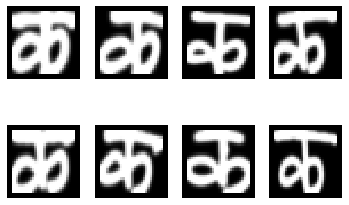

(61640, 1024) (61640,) (30360, 1024) (30360,)


In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, SimpleRNN
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

dataset = pd.read_csv("data.csv")
value_image = pd.DataFrame(dataset.iloc[:,1024].value_counts()).T.rename(index = {0:'null values (nb)'})
row_to_remove = np.where(dataset.iloc[:,1024].values == 1024)

from sklearn import preprocessing
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
# Encode labels in column 'species'.
dataset['character']= label_encoder.fit_transform(dataset['character'])

x = dataset.iloc[:,:-1].values
y = dataset.iloc[:,-1].values
num_pixels = x.shape[1]
num_classes = 46
photo_width = 32
photo_height = 32
photo_depth = 1
x_images = x.reshape(x.shape[0], photo_width, photo_height)
for i in range(1,9):
    plt.subplot(240+i)
    plt.axis('off')
    plt.imshow(x_images[i-1], cmap=plt.get_cmap('gray'))
plt.show()

# split dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

# resize and normalize
image_size = int(np.sqrt(x_train.shape[1]))
x_train = np.reshape(x_train,[-1, image_size * image_size])
x_test = np.reshape(x_test,[-1, image_size* image_size])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

In [2]:
le_name_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(le_name_mapping)

{'character_01_ka': 0, 'character_02_kha': 1, 'character_03_ga': 2, 'character_04_gha': 3, 'character_05_kna': 4, 'character_06_cha': 5, 'character_07_chha': 6, 'character_08_ja': 7, 'character_09_jha': 8, 'character_10_yna': 9, 'character_11_taamatar': 10, 'character_12_thaa': 11, 'character_13_daa': 12, 'character_14_dhaa': 13, 'character_15_adna': 14, 'character_16_tabala': 15, 'character_17_tha': 16, 'character_18_da': 17, 'character_19_dha': 18, 'character_20_na': 19, 'character_21_pa': 20, 'character_22_pha': 21, 'character_23_ba': 22, 'character_24_bha': 23, 'character_25_ma': 24, 'character_26_yaw': 25, 'character_27_ra': 26, 'character_28_la': 27, 'character_29_waw': 28, 'character_30_motosaw': 29, 'character_31_petchiryakha': 30, 'character_32_patalosaw': 31, 'character_33_ha': 32, 'character_34_chhya': 33, 'character_35_tra': 34, 'character_36_gya': 35, 'digit_0': 36, 'digit_1': 37, 'digit_2': 38, 'digit_3': 39, 'digit_4': 40, 'digit_5': 41, 'digit_6': 42, 'digit_7': 43, 'di

In [3]:
import numpy as np
import pickle

np.random.seed(100)
n_tasks = 5

from keras.utils import np_utils

#task_labels = [[0,1], [2,3], [4,5], [6,7], [8,9]]
#task_labels = [[0,1], [2,3], [4,5], [6,7], [8,9]]
task_labels = [[0,1], [2,3], [4,5], [6,7], [8,9], [10, 11], [12,13], [14,15], [16,17], [18,19], [20,21],
              [22,23], [24,25], [26,27], [28,29], [30,31], [32,33], [34,35], [36,37], [38,39], [40,41],
              [42,43], [44,45]]
#task_labels = [[4,2], [0,6], [3,8], [9,7], [1,5],[8,9],[6,7],[5,5],[3,2],[0,1]]
#task_labels = [[16,14], [25, 7], [20, 27], [15, 1], [32, 19]]
#task_labels = [[0,9], [7,8], [3,6], [1,4], [2,5]]
#task_labels = [[9, 3], [1, 8], [7, 4], [0, 5], [6, 2]]
#task_labels = [[0,1], [2,3,1,0],[4,5,1,2], [6,7,3,0],[8,9,4,6]]
n_tasks = len(task_labels)
nb_classes  = num_classes
training_datasets = []
validation_datasets = []
multihead=False

for labels in task_labels:
    idx = np.in1d(y_train, labels)
    if multihead:
        label_map = np.arange(nb_classes)
        label_map[labels] = np.arange(len(labels))
        data = x_train[idx], np_utils.to_categorical(label_map[y_train[idx]], len(labels))
    else:
        data = x_train[idx], np_utils.to_categorical(y_train[idx], nb_classes)
        training_datasets.append(data)

for labels in task_labels:
    idx = np.in1d(y_test, labels)
    if multihead:
        label_map = np.arange(nb_classes)
        label_map[labels] = np.arange(len(labels))
        data = x_test[idx], np_utils.to_categorical(label_map[y_test[idx]], len(labels))
    else:
        data = x_test[idx], np_utils.to_categorical(y_test[idx], nb_classes)
        validation_datasets.append(data)
        
tasks_train={}; labels_train = {}; tasks_test = {}; labels_test = {}

for i in range(len(task_labels)):
    tasks_train[str(i)] = training_datasets[i][0]
    labels_train[str(i)] = training_datasets[i][1]
    tasks_test[str(i)] = validation_datasets[i][0]
    labels_test[str(i)] = validation_datasets[i][1]
    print('Task {0} size: Trainset - {1}, {2}, Testset - {3}, {4}'.format(i,tasks_train[str(i)].shape, labels_train[str(i)].shape, tasks_test[str(i)].shape, labels_test[str(i)].shape))

Tasks_dumped = []
for i in range(len(task_labels)):
    Tasks_dumped.append((tasks_train[str(i)], labels_train[str(i)], tasks_test[str(i)], labels_test[str(i)], tasks_test[str(i)], labels_test[str(i)]))
f = open('devnagri_tasks.pkl', "wb")
pickle.dump(Tasks_dumped, f)
f.close()

Using TensorFlow backend.


Task 0 size: Trainset - (2680, 1024), (2680, 46), Testset - (1320, 1024), (1320, 46)
Task 1 size: Trainset - (2717, 1024), (2717, 46), Testset - (1283, 1024), (1283, 46)
Task 2 size: Trainset - (2663, 1024), (2663, 46), Testset - (1337, 1024), (1337, 46)
Task 3 size: Trainset - (2716, 1024), (2716, 46), Testset - (1284, 1024), (1284, 46)
Task 4 size: Trainset - (2711, 1024), (2711, 46), Testset - (1289, 1024), (1289, 46)
Task 5 size: Trainset - (2688, 1024), (2688, 46), Testset - (1312, 1024), (1312, 46)
Task 6 size: Trainset - (2706, 1024), (2706, 46), Testset - (1294, 1024), (1294, 46)
Task 7 size: Trainset - (2698, 1024), (2698, 46), Testset - (1302, 1024), (1302, 46)
Task 8 size: Trainset - (2613, 1024), (2613, 46), Testset - (1387, 1024), (1387, 46)
Task 9 size: Trainset - (2639, 1024), (2639, 46), Testset - (1361, 1024), (1361, 46)
Task 10 size: Trainset - (2648, 1024), (2648, 46), Testset - (1352, 1024), (1352, 46)
Task 11 size: Trainset - (2657, 1024), (2657, 46), Testset - (13